In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import os
import math # Needed for PositionalEncoding
import json
import time
from torch.cuda.amp import GradScaler, autocast # Import

In [2]:
# --- Helper Functions ---

def move_array_ypos(arr, xpos):
    '''
    Move array to the right by xpos
    '''
    arr = np.roll(arr, xpos)
    if xpos > 0:
        arr[:xpos] = 0
    elif xpos < 0:
        arr[xpos:] = 0
    return arr

def normalize_to_area(signal):
    """Normalizes a 1D signal to have an area (sum) of 1.

    Args:
        signal (torch.Tensor): A tensor representing a 1D signal, shape (..., length).
                               Assumes the last dimension is the sequence length.

    Returns:
        torch.Tensor: Normalized signal, shape (..., length).
                      Returns the original signal if its sum is zero to avoid division by zero.
    """
    # Normalization is commented out in the original code, maintaining that behavior
    # signal_sum = torch.sum(signal, dim=-1, keepdim=True) # Sum along the last dimension (length)
    # Avoid division by zero if the sum is zero (e.g., all zeros input)
    # normalized_signal = torch.where(signal_sum > 0, signal / signal_sum, signal)
    normalized_signal = signal
    return normalized_signal

In [3]:
# --- Dataset ---

class TurbidMediaDataset(Dataset):
    def __init__(self, histograms, irfs, ups, ua):
        self.histograms = histograms
        self.irfs = irfs
        self.ups = ups
        self.ua = ua

    def __len__(self):
        return len(self.histograms)

    def __getitem__(self, idx):
        # Ensure data is float32 numpy array before converting to tensor
        histogram = torch.tensor(self.histograms[idx].astype(np.float32)).unsqueeze(0) # Add channel dimension
        irf = torch.tensor(self.irfs[idx].astype(np.float32)).unsqueeze(0) # Add channel dimension
        ups = torch.tensor(self.ups[idx], dtype=torch.float32)
        ua = torch.tensor(self.ua[idx], dtype=torch.float32)
        # Normalization happens in the training loop / inference if needed
        return histogram, irf, ups, ua

# --- Custom Layers ---

class ExpLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.exp(x)

class PositionalEncoding(nn.Module):
    """Injects positional encoding into the input tensor.
       Taken from PyTorch tutorials: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        # Transpose pe to shape (1, max_len, d_model) to match input B x L x E
        pe = pe.transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        # x is expected to be B x L x E. Add positional encoding based on L.
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [4]:
# --- Transformer Model ---

class TransformerOpticalPropertiesEstimator(nn.Module):
    def __init__(self, config): # Config dictionary as input
        super(TransformerOpticalPropertiesEstimator, self).__init__()
        self.config = config # Store config

        # --- Configuration ---
        input_seq_len = config.get('input_seq_len', 4096) # Length of histogram/IRF
        d_model = config.get('d_model', 128) # Transformer embedding dimension
        nhead = config.get('nhead', 4) # Number of attention heads
        num_encoder_layers = config.get('num_encoder_layers', 3) # Number of transformer layers
        dim_feedforward = config.get('dim_feedforward', 512) # Hidden dim in transformer FFN
        transformer_dropout = config.get('transformer_dropout', 0.1)
        fc_layer_sizes = config.get('fc_layer_sizes', [128, 64]) # FC layer sizes after transformer
        dropout_rate_fc = config.get('dropout_rate_fc', 0.2) # Dropout for FC layers

        # --- Input Embedding ---
        # Use Conv1d as a linear projection from 1 channel to d_model
        self.hist_embedding = nn.Conv1d(1, d_model, kernel_size=1)
        self.irf_embedding = nn.Conv1d(1, d_model, kernel_size=1)

        # --- Positional Encoding ---
        self.pos_encoder = PositionalEncoding(d_model, transformer_dropout, max_len=input_seq_len)

        # --- Transformer Encoder Layers ---
        encoder_layer_hist = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=transformer_dropout,
            activation='relu', # or 'gelu'
            batch_first=True # Important: input format is B x L x E
        )
        self.hist_transformer_encoder = nn.TransformerEncoder(
            encoder_layer_hist,
            num_layers=num_encoder_layers
        )

        encoder_layer_irf = nn.TransformerEncoderLayer(
             d_model=d_model,
             nhead=nhead,
             dim_feedforward=dim_feedforward,
             dropout=transformer_dropout,
             activation='relu', # or 'gelu'
             batch_first=True # Important: input format is B x L x E
        )
        self.irf_transformer_encoder = nn.TransformerEncoder(
            encoder_layer_irf,
            num_layers=num_encoder_layers
        )

        # --- Fully Connected Head ---
        # Input size is d_model from hist + d_model from irf after aggregation
        combined_transformer_output_size = 2 * d_model
        fc_layers = []
        in_features = combined_transformer_output_size

        for layer_size in fc_layer_sizes:
            fc_layers.append(nn.Linear(in_features, layer_size)) # Fully connected layer
            # Consider LayerNorm instead of BatchNorm if preferred for transformers
            fc_layers.append(nn.BatchNorm1d(layer_size)) # Batch norm layer
            fc_layers.append(nn.ReLU()) # ReLU activation
            fc_layers.append(nn.Dropout(dropout_rate_fc)) # Dropout layer
            in_features = layer_size
        fc_layers.append(nn.Linear(in_features, 2)) # Output layer (ups and ua)
        fc_layers.append(ExpLayer()) # Ensure positive output using Exponential activation
        self.fc = nn.Sequential(*fc_layers)

    def forward(self, histogram, irf):
        # Input shapes: (B, 1, L)

        # 1. Embedding
        # Output shape: (B, d_model, L)
        hist_emb = self.hist_embedding(histogram)
        irf_emb = self.irf_embedding(irf)

        # 2. Permute for Transformer (B, L, E)
        # Output shape: (B, L, d_model)
        hist_emb = hist_emb.permute(0, 2, 1)
        irf_emb = irf_emb.permute(0, 2, 1)

        # 3. Add Positional Encoding
        hist_emb_pos = self.pos_encoder(hist_emb)
        irf_emb_pos = self.pos_encoder(irf_emb)

        # 4. Pass through Transformer Encoders
        # Output shape: (B, L, d_model)
        hist_transformer_out = self.hist_transformer_encoder(hist_emb_pos)
        irf_transformer_out = self.irf_transformer_encoder(irf_emb_pos)

        # 5. Aggregate Transformer Output (Mean Pooling over sequence length)
        # Output shape: (B, d_model)
        hist_features = hist_transformer_out.mean(dim=1)
        irf_features = irf_transformer_out.mean(dim=1)

        # 6. Concatenate Features
        # Output shape: (B, 2 * d_model)
        combined_features = torch.cat((hist_features, irf_features), dim=1)

        # 7. Pass through Fully Connected Head
        # Output shape: (B, 2)
        output = self.fc(combined_features)

        return output

In [5]:
# --- Loss Function ---

class MSELossWeightedUA(nn.Module):
    def __init__(self, ua_weight=1.0): # Add ua_weight as a parameter, default to 1.0
        super().__init__()
        self.ua_weight = ua_weight

    def forward(self, predictions, targets):
        # Predictions are already positive due to ExpLayer
        squared_error = (predictions - targets)**2

        # Separate errors for ups and ua
        ups_error = squared_error[:, 0] # Error for ups (first output)
        ua_error = squared_error[:, 1]  # Error for ua (second output)

        # Apply weight to ua error
        weighted_ua_error = self.ua_weight * ua_error

        # Combine the losses (sum and then average)
        loss = torch.mean(ups_error + weighted_ua_error)

        return loss

In [ ]:
# --- Training Function ---

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=100, device="cpu", clip_grad=1.0, patience=10):
    model.to(device)
    train_losses = []
    val_losses = []
    learning_rates = []

    best_val_loss = float('inf') # Initialize best validation loss to infinity
    epochs_no_improve = 0      # Counter for epochs with no improvement
    best_model_state = None    # Store the state of the best model

    print(f"Using device: {device}")

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, (histograms, irfs, ups, ua) in enumerate(train_loader):
            histograms = histograms.to(device)
            irfs = irfs.to(device)
            ups = ups.to(device)
            ua = ua.to(device)

            optimizer.zero_grad()

            # Apply normalization here if desired (as it was in original validation)
            # histograms_normalized = normalize_to_area(histograms)
            # irfs_normalized = normalize_to_area(irfs)
            # outputs = model(histograms_normalized, irfs_normalized)

            outputs = model(histograms, irfs) # Using raw inputs as per original train loop

            targets = torch.stack((ups, ua), dim=1)
            loss = criterion(outputs, targets)
            loss.backward()

            if clip_grad is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad)

            optimizer.step()
            running_loss += loss.item()

            # Optional: Print batch loss
            # if (i + 1) % 10 == 0:
            #     print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for histograms, irfs, ups, ua in val_loader:
                histograms = histograms.to(device)
                irfs = irfs.to(device)
                ups = ups.to(device)
                ua = ua.to(device)

                # Apply normalization consistent with original validation loop
                histograms_normalized = normalize_to_area(histograms)
                irfs_normalized = normalize_to_area(irfs)

                outputs = model(histograms_normalized, irfs_normalized) # Use normalized inputs for validation

                targets = torch.stack((ups, ua), dim=1)
                val_loss = criterion(outputs, targets)
                val_running_loss += val_loss.item()

        epoch_val_loss = val_running_loss / len(val_loader)
        val_losses.append(epoch_val_loss)

        # Step the scheduler AFTER the validation loop
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, LR: {current_lr:.6f}')

        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0 # Reset counter
            best_model_state = model.state_dict() # Save the state of the current best model
            print(f"  New best validation loss: {best_val_loss:.4f}. Saving model state.")
        else:
            epochs_no_improve += 1
            print(f"  Validation loss did not improve for {epochs_no_improve} epoch(s).")


        if epochs_no_improve >= patience:
            print(f'\nEarly stopping triggered after epoch {epoch+1}. Validation loss did not improve for {patience} epochs.')
            if best_model_state:
                print("Loading best model state.")
                model.load_state_dict(best_model_state) # Load the best model state
            else:
                print("Warning: Early stopping triggered but no best model state was saved.")
            break # Stop training

    # Load the best model state if it exists (in case training finished naturally)
    if best_model_state and epochs_no_improve < patience:
         print("\nTraining finished. Loading best model state.")
         model.load_state_dict(best_model_state)

    return model, train_losses, val_losses, learning_rates

In [7]:
# --- Main Script ---

# 1. Data Loading and Preprocessing
rho = 30
sims_folder = os.path.join("SIMs", f"rho{int(rho)}mm") # Use os.path.join for better path handling

print("Running training. Simulation folder: ", sims_folder)

if not os.path.isdir(sims_folder):
    raise FileNotFoundError(f"Simulation folder not found: {sims_folder}")

sim_runs = []
for filename in os.listdir(sims_folder):
    if filename.startswith('sim_results_') and filename.endswith('.npy'):
        suffix = filename.replace('sim_results_', '').replace('.npy', '') # Robust suffix extraction
        sim_runs.append(suffix)

if not sim_runs:
    raise ValueError(f"No simulation files found in {sims_folder}. Check filenames (e.g., 'sim_results_*.npy').")

print(f"Found {len(sim_runs)} simulation runs.")

Running training. Simulation folder:  SIMs/rho30mm
Found 9 simulation runs.


In [8]:
histograms_data = []
irfs_data = []
tags_data = []

for suffix in sim_runs:
    hist_filename = f'sim_results_{suffix}.npy'
    irf_filename = f'sim_irfs_{suffix}.npy'
    tag_filename = f'sim_tags_{suffix}.npy'

    hist_path = os.path.join(sims_folder, hist_filename)
    irf_path = os.path.join(sims_folder, irf_filename)
    tag_path = os.path.join(sims_folder, tag_filename)

    if os.path.exists(hist_path):
        histograms_data.append(np.load(hist_path))
    else:
        print(f"Warning: File not found {hist_path}")
    if os.path.exists(irf_path):
        irfs_data.append(np.load(irf_path))
    else:
        print(f"Warning: File not found {irf_path}")
    if os.path.exists(tag_path):
        tags_data.append(np.load(tag_path))
    else:
        print(f"Warning: File not found {tag_path}")

# Check if any data was loaded
if not histograms_data or not irfs_data or not tags_data:
     raise ValueError("Failed to load necessary data files (.npy). Check file paths and contents.")

In [9]:
# Concatenate and ensure float32
histograms_data = np.concatenate(histograms_data, axis=0).astype(np.float32)
irfs_data = np.concatenate(irfs_data, axis=0).astype(np.float32)
tags_data = np.concatenate(tags_data, axis=0).astype(np.float32)

# Check if dimensions match after concatenation
if not (len(histograms_data) == len(irfs_data) == len(tags_data)):
    raise ValueError("Mismatch in the number of samples between histograms, IRFs, and tags after concatenation.")

ua_data = tags_data[:, 0] # Extract ua (assuming ua is first column)
ups_data = tags_data[:, 1] # Extract ups (assuming ups is second column)

print(f"Total number of samples loaded: {len(ua_data)}")
print(f"Histogram/IRF data shape (first sample): {histograms_data[0].shape}") # Should be (4096,) or similar

Total number of samples loaded: 17000
Histogram/IRF data shape (first sample): (4096,)


In [10]:
# --- Preprocessing & Augmentation ---
cut_threshold = 0.05
max_xpos_roll = 100
min_xpos_roll = -400
savgol_win = 51 # Ensure odd number >= polyorder
savgol_poly = 3

print("Applying preprocessing (Normalization, Smoothing, Cutoff, Rolling)...")
for i in range(len(ua_data)):
    # --- IRF Preprocessing ---
    irf_smooth = savgol_filter(irfs_data[i], savgol_win, savgol_poly)
    irf_max = np.max(irf_smooth)
    if irf_max > 1e-9: # Avoid division by zero/very small numbers
        irfs_data[i] = irfs_data[i] / irf_max
    else:
        irfs_data[i][:] = 0 # Zero out if max is too small
    irfs_data[i][irfs_data[i] < cut_threshold] = 0

    # --- Histogram Preprocessing ---
    hist_smooth = savgol_filter(histograms_data[i], savgol_win, savgol_poly)
    hist_max = np.max(hist_smooth)
    if hist_max > 1e-9:
        histograms_data[i] = histograms_data[i] / hist_max
    else:
         histograms_data[i][:] = 0
    histograms_data[i][histograms_data[i] < cut_threshold] = 0

    # --- Augmentation: Random Roll ---
    irf_xpos_roll = np.random.randint(min_xpos_roll, max_xpos_roll + 1) # +1 for inclusive upper bound
    irfs_data[i] = move_array_ypos(irfs_data[i], irf_xpos_roll)

Applying preprocessing (Normalization, Smoothing, Cutoff, Rolling)...


Plotting example index 7564, ua=0.0031, ups=0.9477


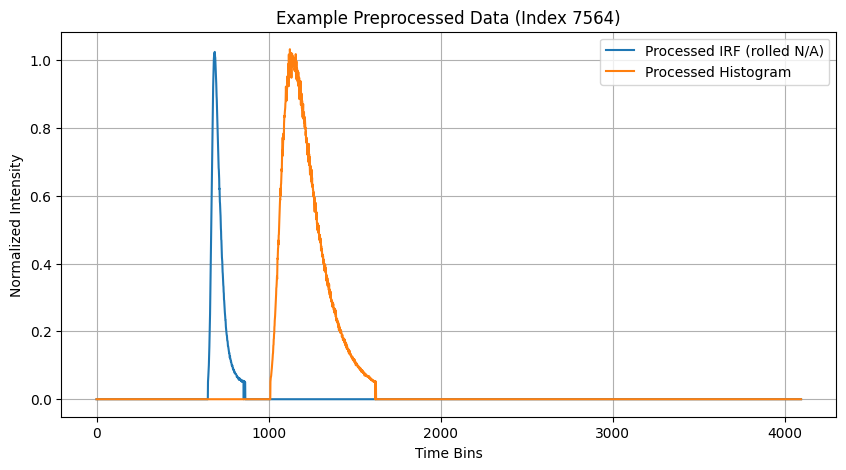

In [11]:
# --- Optional: Plot one example after preprocessing ---
plot_idx = np.random.randint(0, len(ua_data))
print(f"Plotting example index {plot_idx}, ua={ua_data[plot_idx]:.4f}, ups={ups_data[plot_idx]:.4f}")
plt.figure(figsize=(10, 5))
plt.plot(irfs_data[plot_idx], label=f'Processed IRF (rolled {irf_xpos_roll if i==plot_idx else "N/A"})')
plt.plot(histograms_data[plot_idx], label='Processed Histogram')
plt.title(f'Example Preprocessed Data (Index {plot_idx})')
plt.xlabel("Time Bins")
plt.ylabel("Normalized Intensity")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# 2. Split data into training and validation sets
print("Splitting data into training and validation sets...")
histograms_train, histograms_val, irfs_train, irfs_val, ups_train, ups_val, ua_train, ua_val = train_test_split(
    histograms_data, irfs_data, ups_data, ua_data, test_size=0.2, random_state=42
)
print(f"Training set size: {len(histograms_train)}")
print(f"Validation set size: {len(histograms_val)}")


# 3. Create Datasets and DataLoaders
batch_size = 64 # Reduced batch size might be necessary for transformers due to memory
epochs_train = 200 # Adjust as needed
patience_train = 30 # Early stopping patience

print(f"Creating DataLoaders with batch size: {batch_size}")
train_dataset = TurbidMediaDataset(histograms_train, irfs_train, ups_train, ua_train)
val_dataset = TurbidMediaDataset(histograms_val, irfs_val, ups_val, ua_val)
# Consider adding num_workers for faster loading if not on Windows/debugging
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

Splitting data into training and validation sets...
Training set size: 13600
Validation set size: 3400
Creating DataLoaders with batch size: 64


In [13]:
# 4. Define Network Configuration (TRANSFORMER)
# --- Determine input sequence length dynamically ---
seq_len = histograms_data.shape[1] if len(histograms_data) > 0 else 4096 # Default if no data
print(f"Detected sequence length: {seq_len}")

network_config = {
    'input_seq_len': seq_len,        # Sequence length (e.g., 4096)
    'd_model': 128,                  # Transformer embedding dimension & hidden size
    'nhead': 4,                      # Number of attention heads (must divide d_model)
    'num_encoder_layers': 4,         # Number of transformer encoder layers
    'dim_feedforward': 512,          # Hidden dimension in transformer's FFN
    'transformer_dropout': 0.1,      # Dropout rate within transformer layers
    'fc_layer_sizes': [256, 128, 64, 16], # FC layers after transformer aggregation
    'dropout_rate_fc': 0.2,          # Dropout rate in the final FC layers
    # 'use_batchnorm_fc': True       # Kept BatchNorm in FC from original CNN code
}
print("Network Configuration:")
print(json.dumps(network_config, indent=4))


# 5. Initialize Model, Loss function, Optimizer, and Scheduler
print("Initializing Model, Loss, Optimizer, Scheduler...")
model = TransformerOpticalPropertiesEstimator(network_config)

# --- Count Model Parameters (Optional) ---
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

# --- Loss, Optimizer, Scheduler ---
criterion = MSELossWeightedUA(ua_weight=300.0) # Same weighted loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) # Adam is common for transformers, added weight decay
# Scheduler: Reduce LR on plateau or step decay
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True) # Option 1
scheduler = StepLR(optimizer, step_size=40, gamma=0.5) # Option 2: Similar to original

Detected sequence length: 4096
Network Configuration:
{
    "input_seq_len": 4096,
    "d_model": 128,
    "nhead": 4,
    "num_encoder_layers": 4,
    "dim_feedforward": 512,
    "transformer_dropout": 0.1,
    "fc_layer_sizes": [
        256,
        128,
        64,
        16
    ],
    "dropout_rate_fc": 0.2
}
Initializing Model, Loss, Optimizer, Scheduler...
Total trainable parameters: 1,695,634


In [14]:
# 6. Train the Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Starting training for {epochs_train} epochs...")
trained_model, train_losses, val_losses, learning_rates = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler, # Pass the scheduler
    epochs=epochs_train,
    device=device,
    clip_grad=1.0, # Gradient clipping is often helpful for transformers
    patience=patience_train # Use configured patience
)

print("\nTraining finished!")


Starting training for 200 epochs...
Using device: cuda


/tmp/ipykernel_1549116/3013486248.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Initialize GradScaler
/tmp/ipykernel_1549116/3013486248.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Cast operations inside this block to lower precision
/tmp/ipykernel_1549116/3013486248.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


AttributeError: 'TransformerOpticalPropertiesEstimator' object has no attribute 'embed'

In [ ]:
# 7. Plotting Loss Curves
print("Plotting loss curves...")
start_epoch_plot = 10 # Start plotting after initial fluctuations

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(start_epoch_plot, len(train_losses)), train_losses[start_epoch_plot:], label='Train Loss')
plt.plot(range(start_epoch_plot, len(val_losses)), val_losses[start_epoch_plot:], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training & Validation Loss (Epochs {start_epoch_plot+1}-End)')
plt.legend()
plt.grid(True)
plt.yscale('log') # Use log scale for potentially large loss ranges

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(learning_rates, label='Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# 8. Example Inference & Evaluation on Validation Set
print("\nEvaluating model on validation set...")
actual_uas = []
predicted_uas = []
actual_upss = []
predicted_upss = []
error_ua_percent = []
error_ups_percent = []

trained_model.eval() # Set model to evaluation mode
with torch.no_grad():
    for i in range(len(histograms_val)):
        # Prepare single sample batch
        sample_histogram = torch.tensor(histograms_val[i].astype(np.float32)).unsqueeze(0).unsqueeze(0).to(device) # Add batch and channel dim
        sample_irf = torch.tensor(irfs_val[i].astype(np.float32)).unsqueeze(0).unsqueeze(0).to(device) # Add batch and channel dim

        # Normalize inputs consistent with validation during training
        sample_histogram_norm = normalize_to_area(sample_histogram)
        sample_irf_norm = normalize_to_area(sample_irf)

        predicted_optical_properties = trained_model(sample_histogram_norm, sample_irf_norm)

        pred_ups = predicted_optical_properties[0][0].item()
        pred_ua = predicted_optical_properties[0][1].item()
        act_ups = ups_val[i]
        act_ua = ua_val[i]

        predicted_upss.append(pred_ups)
        predicted_uas.append(pred_ua)
        actual_upss.append(act_ups)
        actual_uas.append(act_ua)

        # Calculate percentage error, handle potential division by zero
        if abs(act_ua) > 1e-9:
            error_ua_percent.append(abs((act_ua - pred_ua) / act_ua) * 100)
        else:
            error_ua_percent.append(float('inf') if abs(act_ua - pred_ua) > 1e-6 else 0) # Assign inf if target is near zero but prediction isn't

        if abs(act_ups) > 1e-9:
            error_ups_percent.append(abs((act_ups - pred_ups) / act_ups) * 100)
        else:
             error_ups_percent.append(float('inf') if abs(act_ups - pred_ups) > 1e-6 else 0)


# Calculate median errors, ignoring potential NaNs/Infs
median_error_ups = np.nanmedian([e for e in error_ups_percent if np.isfinite(e)])
median_error_ua = np.nanmedian([e for e in error_ua_percent if np.isfinite(e)])

print(f"\nValidation Set Performance:")
print(f"Median Relative Error in ups: {median_error_ups:.2f}%")
print(f"Median Relative Error in ua:  {median_error_ua:.2f}%")

In [ ]:
# --- Scatter Plots for Error Analysis ---
plt.figure(figsize=(12, 10))

# Error vs Actual
plt.subplot(2, 2, 1)
plt.scatter(actual_uas, error_ua_percent, alpha=0.5, s=10) # Smaller points
plt.xlabel('Actual ua')
plt.ylabel('Relative Error ua (%)')
plt.ylim(0, max(100, np.nanpercentile([e for e in error_ua_percent if np.isfinite(e)], 99) * 1.1 )) # Adjust ylim dynamically
plt.title('Error in ua vs Actual ua')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.scatter(actual_upss, error_ups_percent, alpha=0.5, s=10)
plt.xlabel('Actual ups')
plt.ylabel('Relative Error ups (%)')
plt.ylim(0, max(100, np.nanpercentile([e for e in error_ups_percent if np.isfinite(e)], 99) * 1.1 ))
plt.title('Error in ups vs Actual ups')
plt.grid(True)

# Predicted vs Actual
plt.subplot(2, 2, 3)
min_val_ua = min(min(actual_uas), min(predicted_uas))
max_val_ua = max(max(actual_uas), max(predicted_uas))
plt.scatter(actual_uas, predicted_uas, alpha=0.5, s=10)
plt.plot([min_val_ua, max_val_ua], [min_val_ua, max_val_ua], 'r--', label='Ideal') # Add identity line
plt.xlabel('Actual ua')
plt.ylabel('Predicted ua')
plt.title('Predicted vs Actual ua')
plt.grid(True)
plt.legend()
plt.axis('equal') # Ensure equal scaling for comparison

plt.subplot(2, 2, 4)
min_val_ups = min(min(actual_upss), min(predicted_upss))
max_val_ups = max(max(actual_upss), max(predicted_upss))
plt.scatter(actual_upss, predicted_upss, alpha=0.5, s=10)
plt.plot([min_val_ups, max_val_ups], [min_val_ups, max_val_ups], 'r--', label='Ideal')
plt.xlabel('Actual ups')
plt.ylabel('Predicted ups')
plt.title('Predicted vs Actual ups')
plt.grid(True)
plt.legend()
plt.axis('equal')

plt.tight_layout()
plt.show()


In [ ]:
# 9. Save the trained model and configuration
print("\nSaving trained model and configuration...")
model_folder = f"TrainedModels_Transformer/rho{rho}mm" # Specific folder for transformer models
if not os.path.exists(model_folder):
    os.makedirs(model_folder)
    print(f"Created model directory: {model_folder}")

date_time = time.strftime("%Y%m%d_%H%M%S")
config_filename = f'transformer_config_{date_time}.json'
weights_filename = f'transformer_weights_{date_time}.pth'

config_path = os.path.join(model_folder, config_filename)
weights_path = os.path.join(model_folder, weights_filename)

# Save config
with open(config_path, 'w') as f:
    # Add performance metrics to config for reference
    network_config['training_epochs_run'] = len(train_losses)
    network_config['final_train_loss'] = train_losses[-1] if train_losses else None
    network_config['final_val_loss'] = val_losses[-1] if val_losses else None
    network_config['best_val_loss'] = best_val_loss
    network_config['median_val_error_ups_percent'] = median_error_ups
    network_config['median_val_error_ua_percent'] = median_error_ua
    json.dump(network_config, f, indent=4) # Save with indent for readability
print(f"Configuration saved to: {config_path}")

# Save model weights (state_dict)
# Ensure model is on CPU before saving for better compatibility
trained_model.to('cpu')
torch.save(trained_model.state_dict(), weights_path)
print(f"Model weights saved to: {weights_path}")

print("\nScript finished successfully.")